In [59]:
# Import DoorDash dataset
import pandas as pd
data = pd.read_csv('historical_data.csv')

In [2]:
# General overview of dataset
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [3]:
# Total number of missing values (will need to figure out how to deal with these...fill with default value? mean? ignore record completely?)
data.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [4]:
# Column data types
data.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [60]:
# data['market_id'].value_counts() # 6 unique markets
# data['store_id'].value_counts() # 6743 unique restaurants (many store_ids with only 1 instance--will need to handle for future encoding)
# data['store_primary_category'].value_counts() # 74 unique food categories ('chocolate' and 'alcohol-plus-food' with only 1 instance--will need to handle for future encoding)
# data['order_protocol'].value_counts() # 7 unique order protocols

In [61]:
from statistics import mode

# Create new column denoting total time from order placed to order delivered.
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], errors='coerce')
data['order_to_delivery'] = (data.actual_delivery_time - data.created_at).dt.seconds

# Create new column denoting hr of day order was placed
data['hr_created'] = (data.created_at).dt.hour

# Fill in missing values for various numeric fields. Use mean based on each market_id & hr_created first, since inter-market averages appear to be significantly different from one another
num_cols = ['total_outstanding_orders','total_busy_dashers','total_onshift_dashers']
for col in num_cols:
    data[col] = data[col].fillna(data.groupby(['market_id','hr_created'])[col].transform('mean'))
    data[col] = data[col].fillna(data.groupby('market_id')[col].transform('mean'))

# Fill in missing values for factor variables. Use mode for each market_id.
cat_cols = ['store_primary_category','order_protocol']
for col in cat_cols:
    data[col] = data[col].fillna(data.groupby('market_id')[col].transform(mode))


# Clean up fields that are less than zero, even though they shouldn't be. Will hard code to 0 for sake of feature selection and modelling.
data['total_outstanding_orders'] = [0 if x<0 else x for x in data.total_outstanding_orders]
data['total_busy_dashers'] = [0 if x<0 else x for x in data.total_busy_dashers]
data['total_onshift_dashers'] = [0 if x<0 else x for x in data.total_onshift_dashers]
data['min_item_price'] = [0 if x<0 else x for x in data.min_item_price]

# Create new column denoting percentage of onshift dashers who are busy
data['busy_dasher_pct'] = [1.0 if x>1 else x for x in (data['total_busy_dashers']/data['total_onshift_dashers'])]




<Axes: >

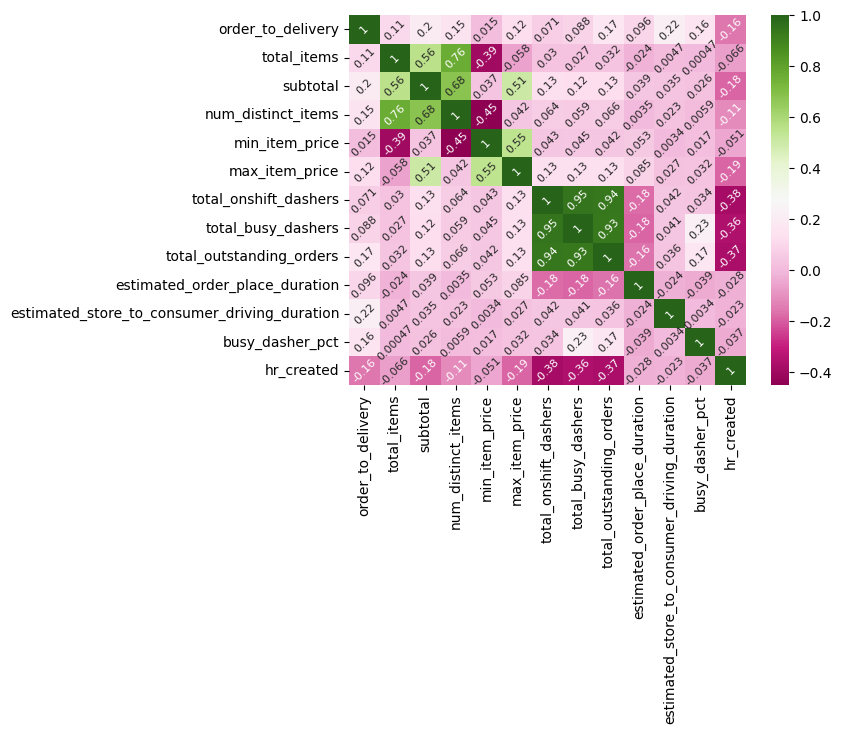

In [62]:
import seaborn as sns

# Plot correlation matrix for numeric variables.
sns.heatmap(data[['order_to_delivery','total_items','subtotal','num_distinct_items','min_item_price','max_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders','estimated_order_place_duration','estimated_store_to_consumer_driving_duration','busy_dasher_pct','hr_created']].corr(), cmap='PiYG', annot=True, annot_kws={'size':8, 'rotation':45})                                 



(Market_id) Test statistic = 1307.9108942551125, P-value = 1.2343539731562903e-280
(Order_protocol) Test statistic = 1970.5381633807563, P-value = 0.0


Text(0.04, 0.5, 'Average time from order placement to delivery (seconds)')

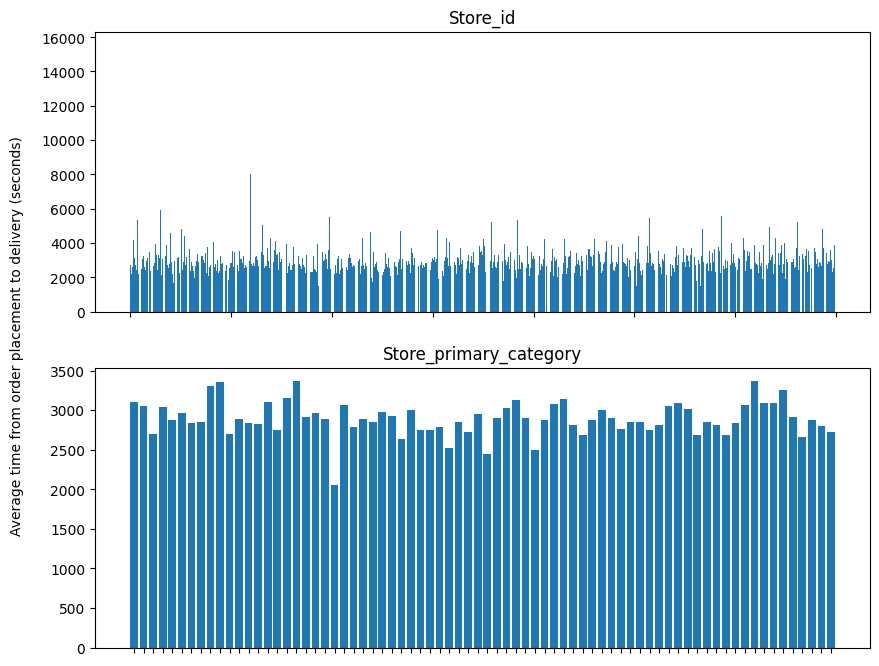

In [63]:
import matplotlib.pyplot as plt
from scipy import stats

# Split values based on market_id for kruskal test
m1 = data[data['market_id']==1.0]['order_to_delivery'].dropna()
m2 = data[data['market_id']==2.0]['order_to_delivery'].dropna()
m3 = data[data['market_id']==3.0]['order_to_delivery'].dropna()
m4 = data[data['market_id']==4.0]['order_to_delivery'].dropna()
m5 = data[data['market_id']==5.0]['order_to_delivery'].dropna()
m6 = data[data['market_id']==6.0]['order_to_delivery'].dropna()
mid_tstat, mid_pval = stats.kruskal(m1, m2, m3, m4, m5, m6)
print(f"(Market_id) Test statistic = {mid_tstat}, P-value = {mid_pval}")

# Split values based on order_protocol
op1 = data[data['order_protocol']==1.0]['order_to_delivery'].dropna()
op2 = data[data['order_protocol']==2.0]['order_to_delivery'].dropna()
op3 = data[data['order_protocol']==3.0]['order_to_delivery'].dropna()
op4 = data[data['order_protocol']==4.0]['order_to_delivery'].dropna()
op5 = data[data['order_protocol']==5.0]['order_to_delivery'].dropna()
op6 = data[data['order_protocol']==6.0]['order_to_delivery'].dropna()
op7 = data[data['order_protocol']==7.0]['order_to_delivery'].dropna()
op_tstat, op_pval = stats.kruskal(op1, op2, op3, op4, op5, op6, op7)
print(f"(Order_protocol) Test statistic = {op_tstat}, P-value = {op_pval}")

store_means = data[['store_id','order_to_delivery']].groupby('store_id').mean('order_to_delivery').reset_index()
storecat_means = data[['store_primary_category','order_to_delivery']].groupby('store_primary_category').mean('order_to_delivery').reset_index()
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,8))
axs[0].bar(store_means['store_id'], store_means['order_to_delivery'])
axs[0].set_xticklabels([])
axs[0].set_title('Store_id')
axs[1].bar(storecat_means['store_primary_category'], storecat_means['order_to_delivery'])
axs[1].set_title('Store_primary_category')
axs[1].set_xticklabels([])
fig.text(0.04, 0.5, 'Average time from order placement to delivery (seconds)', va='center', rotation='vertical')





Based on the exploratory analysis, the following variables will be explored in various models...

    1. Categorical: Market_id, order_protocol
    2. Numerical: hr_created, busy_dasher_pct, estimated_store_to_consumer_driving_duration, total_oustanding_orders, subtotal num_distinct_items

Store_id and store_primary_category will not be included, unless I find a way to bin categories together to reduce the cardinality of those features.



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings(action='ignore',category=DataConversionWarning)

"""
CLEAN AND PREPROCESS DATASET.
"""

modelData = data.copy().dropna(subset=['order_to_delivery'])

X = modelData[['hr_created', 'busy_dasher_pct', 'estimated_store_to_consumer_driving_duration', 'total_outstanding_orders', 'subtotal', 'num_distinct_items','market_id', 'order_protocol']]
y = modelData[['order_to_delivery']]

numbers = ['hr_created', 'busy_dasher_pct', 'estimated_store_to_consumer_driving_duration', 'total_outstanding_orders', 'subtotal', 'num_distinct_items']
categories = ['market_id', 'order_protocol']
target = 'order_to_delivery'

# Setup pipeline to standardize numeric variables and encode categorical varaibles.
num_transform = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_transform = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
InputProcessor = make_column_transformer((num_transform, numbers),(cat_transform, categories))
TargetProcessor = make_pipeline(SimpleImputer(strategy='mean', add_indicator=True), MinMaxScaler())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Fit to the X_train dataset through encoding/standardization, then transform the X_test dataset.
X_train = InputProcessor.fit_transform(X_train)
X_test = InputProcessor.transform(X_test)

# Standardize y_train dataset, then transform the y_test dataset.
y_train = TargetProcessor.fit_transform(y_train)
y_test = TargetProcessor.transform(y_test)


In [21]:
"""
In an attempt to reduce variable list even further, this block will create a basic OLS regression with 
each subset of n predictor variables (n=1,...,8). This will return the best adjusted R^2 value, as well
as the variable set that produced the adjusted R^2 value.
"""

from sklearn.linear_model import LinearRegression
from itertools import combinations
import numpy as np

input = ['hr_created', 'busy_dasher_pct', 'estimated_store_to_consumer_driving_duration', 'total_outstanding_orders', 'subtotal', 'num_distinct_items','market_id', 'order_protocol']
master_vars = []
master_adjr2 = []

for i in range(1,len(input)+1):
    # holds combinations of i length of input variables
    combos = combinations(input, i)
    for c in combos:
        varList = [j for j in c]
        #create regression with X -> var, y -> order_to_delivery
        X_indices = modelData[varList].dropna().index
        X = modelData.loc[X_indices][varList]
        y = modelData.loc[X_indices]['order_to_delivery']
        reg = LinearRegression().fit(X, y)
        r2 = reg.score(X, y)
        n = len(X)
        k = len(varList)
        adjr2 = 1 - (((1-r2)*(n-1)/(n-k-1)))
        master_vars.append(varList)
        master_adjr2.append(adjr2)

print(f"Best adjusted R^2 value: {max(master_adjr2)}")
print(f"Best variable set: {master_vars[np.argmax(master_adjr2)]}")




    



Best adjusted R^2 value: 0.1389856761732654
Best variable set: ['hr_created', 'busy_dasher_pct', 'estimated_store_to_consumer_driving_duration', 'total_outstanding_orders', 'subtotal', 'num_distinct_items', 'market_id', 'order_protocol']


In [10]:
"""
RANDOM FOREST

Include metrics on both train and test sets to identify potential overfitting
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Create base RF model using default parameters. Make predictions on test dataset.
rf = RandomForestRegressor(min_samples_leaf=75, max_depth=5)
rf.fit(X_train, y_train)

pred = TargetProcessor.inverse_transform(rf.predict(X_test).reshape(-1,1))
actual = TargetProcessor.inverse_transform(y_test)


print("==========Random Forest==========")
print("TEST METRICS")
print(f"\tMAE = {mean_absolute_error(actual, pred)}")
print(f"\tMSE = {mean_squared_error(actual, pred)}")
print(f"\tMAPE = {mean_absolute_percentage_error(actual, pred)}")
print("TRAIN METRICS")
print(f"\tMAE = {mean_absolute_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(rf.predict(X_train).reshape(-1,1)))}")
print(f"\tMSE = {mean_squared_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(rf.predict(X_train).reshape(-1,1)))}")
print(f"\tMAPE = {mean_absolute_percentage_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(rf.predict(X_train).reshape(-1,1)))}")




==========Random Forest==========
TEST METRICS
	MAE = 738.9360493083358
	MSE = 1172931.3050431048
	MAPE = 0.2815439342639539
TRAIN METRICS
	MAE = 737.608611914845
	MSE = 1191216.7740052454
	MAPE = 0.2806435114092597


In [37]:
"""
EXTREME GRADIENT BOOSTER
"""
import xgboost as xgb

xgbModel = xgb.XGBRegressor(booster='gblinear')
xgbModel.fit(X_train, y_train)

pred2 = TargetProcessor.inverse_transform(xgbModel.predict(X_test).reshape(-1,1))

print("==========XGBoost==========")
print("TEST METRICS")
print(f"\tMAE = {mean_absolute_error(actual, pred2)}")
print(f"\tMSE = {mean_squared_error(actual, pred2)}")
print(f"\tMAPE = {mean_absolute_percentage_error(actual, pred2)}")
print("TRAIN METRICS")
print(f"\tMAE = {mean_absolute_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(xgbModel.predict(X_train).reshape(-1,1)))}")
print(f"\tMSE = {mean_squared_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(xgbModel.predict(X_train).reshape(-1,1)))}")
print(f"\tMAPE = {mean_absolute_percentage_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(xgbModel.predict(X_train).reshape(-1,1)))}")







==========XGBoost==========
TEST METRICS
	MAE = 724.9114894642481
	MSE = 1076650.805783809
	MAPE = 0.2732897817060476
TRAIN METRICS
	MAE = 724.5854704238669
	MSE = 1195233.5430030476
	MAPE = 0.27304691961117816


In [11]:
""" 
GAM
"""
from pygam import LinearGAM, s, f

gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18))
gam.gridsearch(X_train, y_train, progress=False)
#gam.summary()

pred3 = TargetProcessor.inverse_transform(gam.predict(X_test).reshape(-1,1))


print("==========GAM==========")
print("TEST METRICS")
print(f"\tMAE = {mean_absolute_error(actual, pred3)}")
print(f"\tMSE = {mean_squared_error(actual, pred3)}")
print(f"\tMAPE = {mean_absolute_percentage_error(actual, pred3)}")
print("TRAIN METRICS")
print(f"\tMAE = {mean_absolute_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(gam.predict(X_train).reshape(-1,1)))}")
print(f"\tMSE = {mean_squared_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(gam.predict(X_train).reshape(-1,1)))}")
print(f"\tMAPE = {mean_absolute_percentage_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(gam.predict(X_train).reshape(-1,1)))}")





==========GAM==========
TEST METRICS
	MAE = 709.6698596071791
	MSE = 1093300.9260779521
	MAPE = 0.2659137972752461
TRAIN METRICS
	MAE = 707.2301164183314
	MSE = 1119587.5835499046
	MAPE = 0.26480011459246566


1851/1851 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step
==========Neural Network==========
Lowest scaled validation loss (MAE) = 0.009270216338336468 @ epoch 31


TEST METRICS
	MAE = 685.9235065813226
	MSE = 1130424.953316257
	MAPE = 0.23965158579178766
TRAIN METRICS
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 3s 740us/step
	MAE = 677.8575129794466
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step
	MSE = 1139188.2874825597
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step
	MAPE = 0.23616916266229726


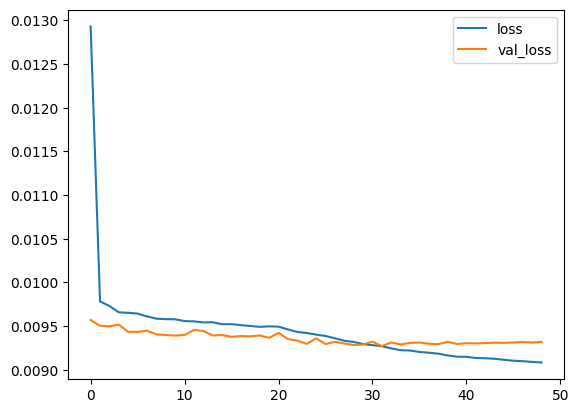

In [13]:
""" 
NEURAL NETWORK
"""
import setuptools.dist
from tensorflow import keras
from tensorflow.keras import layers, callbacks 
import numpy as np

input_shape=X_train.shape[1]

# Neural network w/ 3 hidden layers: each with 128 units.
nnMod = keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.RandomNormal(), bias_initializer=keras.initializers.RandomNormal()),
    layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.RandomNormal(), bias_initializer=keras.initializers.RandomNormal()),
    layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.RandomNormal(), bias_initializer=keras.initializers.RandomNormal()),
    layers.Dropout(0.4),
    layers.Dense(1)
])

# Add callbacks for model tuning
def scheduler(epoch, lr):
    if epoch < 25:
        return lr
    else:
        return lr*np.exp(-0.1)
    
callback1 = callbacks.LearningRateScheduler(scheduler)
callback2 = callbacks.EarlyStopping(monitor='val_loss',
                                    mode='min',
                                    min_delta=0.0001,
                                    patience=25,
                                    restore_best_weights=True,
                                    start_from_epoch=20   #to account for learning rate change first change at epoch 25
                                    )

nnMod.compile(optimizer=keras.optimizers.Adam(),
              loss='mae')

history = nnMod.fit(
    X_train, y_train, 
    validation_split=0.3,
    batch_size=512,
    epochs=200,
    callbacks=[callback1, callback2],
    verbose=0
)

historyDF = pd.DataFrame(history.history)
historyDF[['loss','val_loss']].plot()

pred4 = TargetProcessor.inverse_transform(nnMod.predict(X_test))
print("==========Neural Network==========")
print(f"Lowest scaled validation loss (MAE) = {min(historyDF['val_loss'])} @ epoch {np.argmin(historyDF['val_loss'])}")
print("\n")
print("TEST METRICS")
print(f"\tMAE = {mean_absolute_error(actual, pred4)}")
print(f"\tMSE = {mean_squared_error(actual, pred4)}")
print(f"\tMAPE = {mean_absolute_percentage_error(actual, pred4)}")
print("TRAIN METRICS")
print(f"\tMAE = {mean_absolute_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(nnMod.predict(X_train)))}")
print(f"\tMSE = {mean_squared_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(nnMod.predict(X_train)))}")
print(f"\tMAPE = {mean_absolute_percentage_error(TargetProcessor.inverse_transform(y_train), TargetProcessor.inverse_transform(nnMod.predict(X_train)))}")





